# 🎧 Task 3 — Faster-Whisper Optimization  
### Section 1 — Environment Setup & System Check  

This notebook focuses on **optimizing the Faster-Whisper model** for resource usage, audio preprocessing, and error handling.

**Notebook name:** `task3_fasterwhisper_optimization.ipynb`  
**Purpose of this section:**  
Set up the environment and verify system resources before running any optimization or audio tests.

---

### What will happen in this section:
1. Install all necessary dependencies for Task 3.  
2. Prepare workspace folders (for logs, results, and sample audio).  
3. Check system details — GPU availability, CPU info, and memory stats.  
4. Add a small helper function to capture live resource usage snapshots.  
5. Print clear reminders about how to save and submit the notebook.  

Let's begin by installing dependencies.


## 🧰 Step 1: Install Required Libraries  

In this step, we install all the Python packages needed for:
- Faster-Whisper model loading and transcription.  
- Audio loading and processing.  
- Resource monitoring and visualization.

> ⚙️ Run this cell once at the beginning of every new Colab session.


In [2]:
# Run this as a code cell (leading !). Adjust versions if you have project constraints.
# Keep installs minimal to avoid long setup time. Add more later if needed.
!pip install --quiet faster-whisper psutil soundfile librosa matplotlib tqdm
# If you plan to use rnnoise or other native packages, install them later when needed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


## 📂 Step 2: Prepare Workspace  

We’ll now create a simple workspace inside Colab to keep things organized.  
This includes:
- `results/` — to save any figures or CSVs generated later.  
- `logs/` — to record error messages and performance metrics.  
- `data/` — where we’ll upload and keep audio samples for testing.

> These folders will exist temporarily during this Colab session.


In [3]:
# Standard imports
import os, sys, time, subprocess
import psutil
import platform
import math
from datetime import datetime

# Set a workspace in the ephemeral Colab VM (no Drive mount).
# This is where we'll store results/logs during this session.
BASE_DIR = "/content/visionai_task3"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
LOGS_DIR = os.path.join(BASE_DIR, "logs")
DATA_DIR = os.path.join(BASE_DIR, "data")   # you can upload test audio to this during session

# Create directories
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print("Workspace prepared:")
print(" BASE_DIR:", BASE_DIR)
print(" RESULTS_DIR:", RESULTS_DIR)
print(" LOGS_DIR:", LOGS_DIR)
print(" DATA_DIR:", DATA_DIR)


Workspace prepared:
 BASE_DIR: /content/visionai_task3
 RESULTS_DIR: /content/visionai_task3/results
 LOGS_DIR: /content/visionai_task3/logs
 DATA_DIR: /content/visionai_task3/data


## 🖥️ Step 3: Check System Resources  

Before running the model, let’s check:
- Python version and environment details  
- CPU core count and available RAM  
- GPU availability (if Colab GPU runtime is active)

This gives us a baseline understanding of what resources we have available for optimization experiments.


In [4]:
# GPU detection and resource summary
def show_system_info():
    print("===== SYSTEM INFO =====")
    print("Platform:", platform.platform())
    print("Python:", sys.version.splitlines()[0])
    print("Now:", datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC"))
    print()
    # CPU & RAM
    print("CPU physical cores:", psutil.cpu_count(logical=False))
    print("CPU logical cores:", psutil.cpu_count(logical=True))
    ram_gb = psutil.virtual_memory().total / (1024**3)
    print("Total RAM (GB):", round(ram_gb, 2))
    # Disk free in GB
    st = os.statvfs(BASE_DIR)
    free_gb = (st.f_bavail * st.f_frsize) / (1024**3)
    print("Disk free (GB) at BASE_DIR:", round(free_gb, 2))

    # GPU (nvidia-smi) check
    print()
    print("===== GPU INFO =====")
    try:
        gpu_output = subprocess.getoutput("nvidia-smi --query-gpu=name,memory.total,driver_version --format=csv,noheader")
        if gpu_output.strip():
            print("nvidia-smi output:")
            print(gpu_output)
        else:
            print("No GPU detected or nvidia-smi not available in this runtime.")
    except Exception as e:
        print("nvidia-smi check failed:", e)

show_system_info()


===== SYSTEM INFO =====
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Now: 2025-10-16 08:00:49 UTC

CPU physical cores: 1
CPU logical cores: 2
Total RAM (GB): 12.67
Disk free (GB) at BASE_DIR: 72.81

===== GPU INFO =====
nvidia-smi output:
Tesla T4, 15360 MiB, 550.54.15


/tmp/ipython-input-172964212.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print("Now:", datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC"))


## 📊 Step 4: Define a Resource Snapshot Helper  

We’ll now define a small function to capture the system’s current usage (CPU, RAM, GPU).  
Later, we can call this function during transcription to monitor how resource usage changes.


In [5]:
import json

def resource_snapshot():
    """Return a dict snapshot of CPU, RAM and (if available) GPU memory usage."""
    snap = {
        "time_utc": datetime.utcnow().isoformat(),
        "cpu_percent": psutil.cpu_percent(interval=0.5),
        "ram_percent": psutil.virtual_memory().percent,
        "ram_used_gb": round(psutil.virtual_memory().used / (1024**3), 3),
        "ram_total_gb": round(psutil.virtual_memory().total / (1024**3), 3),
    }
    # Attempt to get GPU info via nvidia-smi
    try:
        ginfo = subprocess.getoutput("nvidia-smi --query-gpu=index,name,utilization.gpu,memory.used,memory.total --format=csv,noheader")
        if ginfo.strip():
            # produce a list of GPU entries
            entries = []
            for line in ginfo.strip().splitlines():
                parts = [p.strip() for p in line.split(",")]
                entries.append({
                    "index": parts[0],
                    "name": parts[1],
                    "utilization": parts[2],
                    "mem_used": parts[3],
                    "mem_total": parts[4]
                })
            snap["gpus"] = entries
    except Exception:
        snap["gpus"] = []

    return snap

# Example usage: print a snapshot
print(json.dumps(resource_snapshot(), indent=2))


/tmp/ipython-input-3051626859.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time_utc": datetime.utcnow().isoformat(),


{
  "time_utc": "2025-10-16T08:00:49.466421",
  "cpu_percent": 6.1,
  "ram_percent": 8.1,
  "ram_used_gb": 0.71,
  "ram_total_gb": 12.671,
  "gpus": [
    {
      "index": "0",
      "name": "Tesla T4",
      "utilization": "0 %",
      "mem_used": "0 MiB",
      "mem_total": "15360 MiB"
    }
  ]
}


# 🎵 Section 2 — Data & Audio Loading  

In this section, we’ll:
1. Upload sample audio files directly into Colab.  
2. Validate file integrity and confirm supported audio formats.  
3. Convert any uploaded audio to **mono, 16 kHz WAV**, which is the recommended format for Whisper models.  
4. Display a waveform and spectrogram to visually inspect audio quality.

These steps ensure all input data is clean and consistent before we begin optimization experiments.


## 📤 Step 1: Upload Audio Files  

Use Colab’s upload widget to import a few audio samples (e.g. `.wav`, `.mp3`, `.m4a`).

Once uploaded, they’ll appear in `/content/visionai_task3/data/`.  
We’ll later use them to test preprocessing and Faster-Whisper performance.


In [6]:
from google.colab import files
import shutil

print("📁 Please choose audio files to upload (one or more).")
uploaded = files.upload()

for fname in uploaded.keys():
    dest_path = os.path.join(DATA_DIR, fname)
    shutil.move(fname, dest_path)
    print(f"✅ Saved: {dest_path}")

print("\nUploaded files now available in:", DATA_DIR)
print("Files:", os.listdir(DATA_DIR))


📁 Please choose audio files to upload (one or more).


Saving corrupted_audio.mp3 to corrupted_audio.mp3
Saving fake_audio.mp3 to fake_audio.mp3
Saving urdu_whatsapp_like_voice_15min.mp3 to urdu_whatsapp_like_voice_15min.mp3
Saving en_UK_US_multiple_accent_noisy_background_music_50s.mp3 to en_UK_US_multiple_accent_noisy_background_music_50s.mp3
Saving eng_Pk_accent_clean_30s.wav to eng_Pk_accent_clean_30s.wav
Saving eng_UK_clean_repeated_sentences_50s.m4a to eng_UK_clean_repeated_sentences_50s.m4a
Saving english_multi_accent_noisy_background_3min.mp3 to english_multi_accent_noisy_background_3min.mp3
Saving ur_clean_bot_like_30s.mp3 to ur_clean_bot_like_30s.mp3
Saving ur_noisy_background_music_5min.mp3 to ur_noisy_background_music_5min.mp3
Saving urdu_low_pitch_fast_speaking_rate_15s_.mp3 to urdu_low_pitch_fast_speaking_rate_15s_.mp3
Saving english_clean_1min.mp3 to english_clean_1min.mp3
Saving urdu_F_clean_30s.mp3 to urdu_F_clean_30s.mp3
Saving urdu_silence_1min.wav to urdu_silence_1min.wav
Saving eng_clean_16min.mp3 to eng_clean_16min.mp

## ✅ Step 2: Validate Audio Files  

We’ll now:
- Confirm each uploaded file exists and can be read by the audio library.  
- Catch unsupported or corrupted files early.  
- Print duration and sample rate for a quick overview.


In [8]:
import soundfile as sf

def validate_audio_files(folder_path):
    info_list = []
    for file in os.listdir(folder_path):
        fpath = os.path.join(folder_path, file)
        try:
            data, sr = sf.read(fpath)
            duration = round(len(data) / sr, 2)
            info_list.append({
                "file": file,
                "sample_rate": sr,
                "duration_sec": duration,
                "status": "OK"
            })
        except Exception as e:
            info_list.append({
                "file": file,
                "sample_rate": None,
                "duration_sec": None,
                "status": f"ERROR: {e}"
            })
    return info_list

file_info = validate_audio_files(DATA_DIR)
for f in file_info:
    print(f)


{'file': 'en_UK_US_multiple_accent_noisy_background_music_50s.mp3', 'sample_rate': 44100, 'duration_sec': 47.1, 'status': 'OK'}
{'file': 'corrupted_audio.mp3', 'sample_rate': None, 'duration_sec': None, 'status': "ERROR: Error opening '/content/visionai_task3/data/corrupted_audio.mp3': File does not exist or is not a regular file (possibly a pipe?)."}
{'file': 'english_multi_accent_noisy_background_3min.mp3', 'sample_rate': 44100, 'duration_sec': 228.36, 'status': 'OK'}
{'file': 'urdu_F_clean_30s.mp3', 'sample_rate': 48000, 'duration_sec': 21.41, 'status': 'OK'}
{'file': 'converted', 'sample_rate': None, 'duration_sec': None, 'status': "ERROR: Error opening '/content/visionai_task3/data/converted': Format not recognised."}
{'file': 'urdu_silence_1min.wav', 'sample_rate': 48000, 'duration_sec': 95.48, 'status': 'OK'}
{'file': 'eng_Pk_accent_clean_30s.wav', 'sample_rate': 48000, 'duration_sec': 25.51, 'status': 'OK'}
{'file': 'unsupported_encoding_settings.mp4', 'sample_rate': None, 'dur

## 🎚️ Step 3 (Updated): Convert Audio to Mono 16 kHz WAV  

We’ll now handle corrupted or unsupported files more safely.  
This updated version:
- Converts only valid audio files.  
- Skips any file that can’t be decoded.  
- Prints a clear message for each file (✅ success / ⚠️ skipped).


In [16]:
import librosa
import numpy as np
import soundfile as sf
from datetime import datetime

CONVERTED_DIR = os.path.join(DATA_DIR, "converted")
LOG_FILE = os.path.join(LOGS_DIR, "validation.log")

os.makedirs(CONVERTED_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

def log_message(message):
    """Append message to log file with timestamp."""
    timestamp = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    with open(LOG_FILE, "a") as f:
        f.write(f"[{timestamp}] {message}\n")

def convert_to_mono_16k_safe(src_path, dst_path):
    """Convert audio to 16 kHz mono safely, logging all results."""
    file_name = os.path.basename(src_path)
    try:
        y, sr = librosa.load(src_path, sr=16000, mono=True)
        if y is None or len(y) == 0:
            msg = f"⚠️ EMPTY: {file_name} — No samples detected"
            print(msg)
            log_message(msg)
            return None
        sf.write(dst_path, y, 16000)
        duration = len(y) / 16000
        msg = f"OK: {file_name} converted successfully ({duration:.2f}s)"
        print(f"✅ {msg}")
        log_message(msg)
        return duration
    except Exception as e:
        msg = f"ERROR: {file_name} — {str(e)}"
        print(f"❌ {msg}")
        log_message(msg)
        return None

print("🔄 Converting valid audio files to 16 kHz mono...\n")

for file in os.listdir(DATA_DIR):
    if not file.lower().endswith((".wav", ".mp3", ".m4a")):
        continue
    if "converted" in file.lower():
        continue
    src = os.path.join(DATA_DIR, file)
    dst = os.path.join(CONVERTED_DIR, os.path.splitext(file)[0] + "_16k.wav")
    dur = convert_to_mono_16k_safe(src, dst)
    if dur:
        print(f"✅ Converted: {file} → {os.path.basename(dst)} ({dur:.2f}s)")
    else:
        print(f"⚠️ Skipped conversion for {file}")

print("\nAll convertible files processed.")
print(f"📜 Log file saved at: {LOG_FILE}")


🔄 Converting valid audio files to 16 kHz mono...

✅ OK: en_UK_US_multiple_accent_noisy_background_music_50s.mp3 converted successfully (47.10s)
✅ Converted: en_UK_US_multiple_accent_noisy_background_music_50s.mp3 → en_UK_US_multiple_accent_noisy_background_music_50s_16k.wav (47.10s)


/tmp/ipython-input-4293597104.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
/tmp/ipython-input-4293597104.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(src_path, sr=16000, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


❌ ERROR: corrupted_audio.mp3 — float division by zero
⚠️ Skipped conversion for corrupted_audio.mp3


/tmp/ipython-input-4293597104.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")


✅ OK: english_multi_accent_noisy_background_3min.mp3 converted successfully (228.36s)
✅ Converted: english_multi_accent_noisy_background_3min.mp3 → english_multi_accent_noisy_background_3min_16k.wav (228.36s)
✅ OK: urdu_F_clean_30s.mp3 converted successfully (21.41s)
✅ Converted: urdu_F_clean_30s.mp3 → urdu_F_clean_30s_16k.wav (21.41s)
✅ OK: urdu_silence_1min.wav converted successfully (95.48s)
✅ Converted: urdu_silence_1min.wav → urdu_silence_1min_16k.wav (95.48s)
✅ OK: eng_Pk_accent_clean_30s.wav converted successfully (25.51s)
✅ Converted: eng_Pk_accent_clean_30s.wav → eng_Pk_accent_clean_30s_16k.wav (25.51s)
✅ OK: eng_clean_16min.mp3 converted successfully (972.83s)
✅ Converted: eng_clean_16min.mp3 → eng_clean_16min_16k.wav (972.83s)
✅ OK: urdu_whatsapp_like_voice_15min.mp3 converted successfully (936.33s)
✅ Converted: urdu_whatsapp_like_voice_15min.mp3 → urdu_whatsapp_like_voice_15min_16k.wav (936.33s)
✅ OK: ur_clean_bot_like_30s.mp3 converted successfully (27.00s)
✅ Converted: ur

/tmp/ipython-input-4293597104.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(src_path, sr=16000, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


✅ OK: eng_UK_clean_repeated_sentences_50s.m4a converted successfully (50.37s)
✅ Converted: eng_UK_clean_repeated_sentences_50s.m4a → eng_UK_clean_repeated_sentences_50s_16k.wav (50.37s)
❌ ERROR: fake_audio.mp3 — 
⚠️ Skipped conversion for fake_audio.mp3


/tmp/ipython-input-4293597104.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
/tmp/ipython-input-4293597104.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(src_path, sr=16000, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-4293597104.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftim

✅ OK: ur_noisy_background_music_5min.mp3 converted successfully (295.81s)
✅ Converted: ur_noisy_background_music_5min.mp3 → ur_noisy_background_music_5min_16k.wav (295.81s)

All convertible files processed.
📜 Log file saved at: /content/visionai_task3/logs/validation.log


## 🎨 Step 4: Visualizing the Audio Data  

Now that all audios are preprocessed into 16 kHz mono WAV format,  
let’s visualize their **waveform** and **mel spectrograms** to better understand the acoustic patterns and quality of the recordings.  

---

### **Waveform Plot**
The waveform represents how the **amplitude (loudness)** of the audio changes over time.

- Each vertical “spike” or line corresponds to a burst of sound energy (like speech, music, or noise).  
- **Dense regions** (where lines are tightly packed) indicate continuous sound — e.g., fast speech or background noise.  
- **Sparse or flat regions** represent silence or pauses.  
- **Very large spikes** can mean sudden loud noises or clipping/distortion.  
- This plot is helpful for identifying:
  - Where speech starts and ends.
  - How noisy the recording is.
  - Whether the audio has balanced loudness or uneven gain.

---

### **Mel Spectrogram Plot**
The mel spectrogram shows the **energy distribution across frequencies** (y-axis) over time (x-axis),  
converted to the **mel scale** — which approximates how human ears perceive pitch.

- **Bright yellow/orange regions** → high energy (speech, music, strong consonants like “s” or “t”).  
- **Dark blue or black regions** → silence or low energy.  
- **Horizontal lines** → constant tones (like hum, background music, or static noise).  
- **Vertical stripes** → transient bursts (like speech syllables, claps, or clicks).  
- You can tell:
  - How much noise or background sound exists (broad, blurry colors).
  - Whether the recording contains clear speech (distinct vertical patterns).
  - Which portions of the file are most informative for transcription.

---

Together, these plots give a quick visual summary of:
- **Audio quality** (clean vs. noisy)
- **Speaking style** (slow vs. fast)
- **Energy distribution** (speech vs. silence vs. background)
  
This visualization step helps confirm whether preprocessing worked correctly before feeding the data to Whisper.


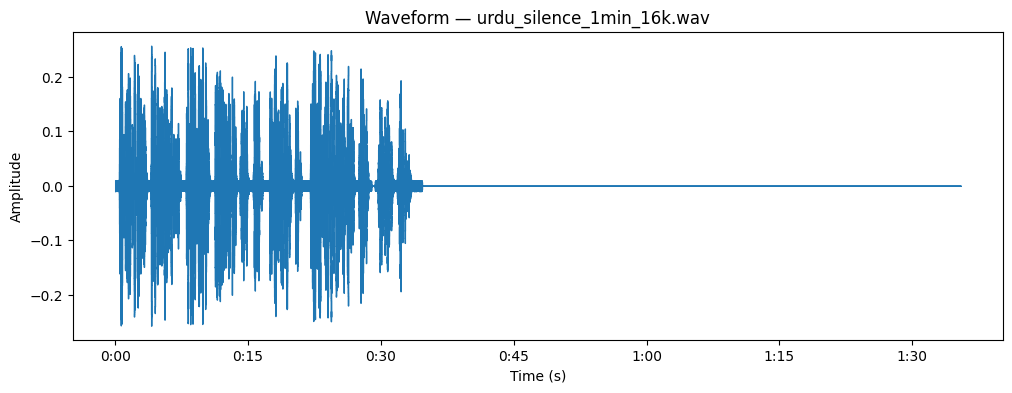

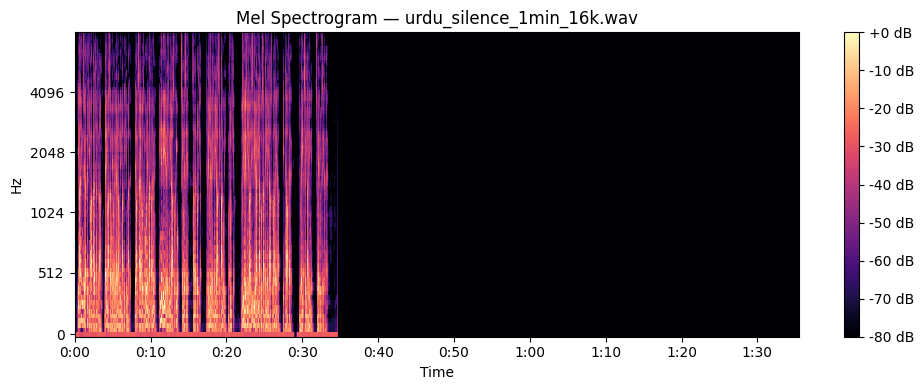

In [21]:
import matplotlib.pyplot as plt

# Pick the first converted file for visualization
sample_file = os.listdir(CONVERTED_DIR)[10]
sample_path = os.path.join(CONVERTED_DIR, sample_file)

y, sr = librosa.load(sample_path, sr=None)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform — {sample_file}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Spectrogram
plt.figure(figsize=(10, 4))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram — {sample_file}")
plt.tight_layout()
plt.show()


## 🧾 Section 2 Summary  

✅ Uploaded audio files successfully.  
✅ Validated and converted to mono 16 kHz WAV.  
✅ Visualized waveform and spectrogram.

Next, in **Section 3**, we’ll integrate these prepared audio files into the Faster-Whisper pipeline to test:
- Different beam sizes, chunk lengths, and batch sizes.  
- Resource usage and speed for each configuration.  
- Performance logging for optimization analysis.

# ⚙️ Section 3 — Faster-Whisper Model Optimization  

In this section, we’ll:
1. Load the **Faster-Whisper** model selected from Task 2.  
2. Configure **inference precision** (`float16`, `int8`, etc.) and **device (GPU/CPU)**.  
3. Prepare functions to benchmark **speed**, **resource usage**, and **transcription accuracy**.  

This forms the base for all optimization experiments we’ll conduct later.


## 🧰 Step 1: Load the Faster-Whisper Model  

We start by loading the Whisper model in the appropriate precision and device mode.  

- **float16** → Faster GPU inference with minimal accuracy loss.  
- **int8** → Lighter CPU inference (used when GPU unavailable).  

> Note: First-time load may take up to 30 s as the model downloads.


In [22]:
from faster_whisper import WhisperModel
import torch, time

MODEL_NAME = "large-v3"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COMPUTE_TYPE = "float16" if DEVICE == "cuda" else "int8"

print(f"🚀 Loading Faster-Whisper model: {MODEL_NAME}")
print(f"Device: {DEVICE} | Compute Type: {COMPUTE_TYPE}")

t0 = time.time()
model = WhisperModel(MODEL_NAME, device=DEVICE, compute_type=COMPUTE_TYPE)
load_time = time.time() - t0
print(f"✅ Model loaded successfully in {load_time:.2f} s")

if DEVICE == "cuda":
    print(f"🔋 GPU in use: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Running on CPU — inference will be slower.")


🚀 Loading Faster-Whisper model: large-v3
Device: cuda | Compute Type: float16


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

vocabulary.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

✅ Model loaded successfully in 63.23 s
🔋 GPU in use: Tesla T4


## ✅ Step 2: Verify Model Readiness  

We’ll now:
- Print available model configuration options (language, task, beam size, etc.)  
- Ensure the model is ready to run test transcriptions.  
- Capture a resource snapshot for baseline comparison.


In [23]:
# Check available parameters and default decoding options
import inspect

print("Model attributes:", [m for m in dir(model) if not m.startswith("_")][:10])
print("\nTranscription method signature:\n")
print(inspect.signature(model.transcribe))

# Baseline resource snapshot
print("\n📊 Baseline Resource Snapshot:")
print(json.dumps(resource_snapshot(), indent=2))


Model attributes: ['add_word_timestamps', 'detect_language', 'encode', 'feat_kwargs', 'feature_extractor', 'find_alignment', 'frames_per_second', 'generate_segments', 'generate_with_fallback', 'get_prompt']

Transcription method signature:

(audio: Union[str, BinaryIO, numpy.ndarray], language: Optional[str] = None, task: str = 'transcribe', log_progress: bool = False, beam_size: int = 5, best_of: int = 5, patience: float = 1, length_penalty: float = 1, repetition_penalty: float = 1, no_repeat_ngram_size: int = 0, temperature: Union[float, List[float], Tuple[float, ...]] = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], compression_ratio_threshold: Optional[float] = 2.4, log_prob_threshold: Optional[float] = -1.0, no_speech_threshold: Optional[float] = 0.6, condition_on_previous_text: bool = True, prompt_reset_on_temperature: float = 0.5, initial_prompt: Union[str, Iterable[int], NoneType] = None, prefix: Optional[str] = None, suppress_blank: bool = True, suppress_tokens: Optional[List[int]] = [-1], w

/tmp/ipython-input-3051626859.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time_utc": datetime.utcnow().isoformat(),


{
  "time_utc": "2025-10-16T09:41:51.475665",
  "cpu_percent": 1.0,
  "ram_percent": 43.6,
  "ram_used_gb": 5.205,
  "ram_total_gb": 12.671,
  "gpus": [
    {
      "index": "0",
      "name": "Tesla T4",
      "utilization": "0 %",
      "mem_used": "3206 MiB",
      "mem_total": "15360 MiB"
    }
  ]
}


## 🎤 Step 3: Quick Sanity Test  

Before running full benchmarks, let’s transcribe one short audio sample  
to confirm everything works end-to-end (model + audio + output + device).  

We’ll use one converted file (e.g. a clean English sample) and print the first few transcribed lines.


In [25]:
import random
import datetime

converted_files = [f for f in os.listdir(CONVERTED_DIR) if f.endswith(".wav")]
test_file = random.choice(converted_files)
test_path = os.path.join(CONVERTED_DIR, test_file)

print(f"🎧 Testing file: {test_file}")
print(f"Started at: {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")

t0 = time.time()
segments, info = model.transcribe(test_path, beam_size=5, language="en")
t1 = time.time()

print(f"⏱️ Transcription completed in {(t1 - t0):.2f} s")
print(f"Duration: {info.duration:.2f} s, Language: {info.language}")

print("\nSample output:")
for i, segment in enumerate(segments):
    print(f"[{segment.start:.2f}s – {segment.end:.2f}s] {segment.text}")
    if i >= 3:  # show only first few lines
        break


🎧 Testing file: urdu_low_pitch_fast_speaking_rate_15s__16k.wav
Started at: 2025-10-16 09:43:18 UTC


/tmp/ipython-input-1471412749.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"Started at: {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")


⏱️ Transcription completed in 0.22 s
Duration: 13.37 s, Language: en

Sample output:
[0.00s – 2.04s]  Life is a journey that teaches us something new at every moment.
[2.54s – 4.88s]  Sometimes happiness, sometimes sorrow, sometimes success, sometimes failure.
[4.98s – 7.98s]  But the real power is in this moment when we take a step forward instead of giving up.
[8.60s – 10.88s]  Remember, after every dark night, a bright morning definitely comes.


## 🧾 Section 3 Summary  

✅ Loaded the Faster-Whisper model (GPU/CPU optimized).  
✅ Verified model configuration and environment readiness.  
✅ Ran a short audio sample for sanity check.  

Next, in **Section 4**, we will:
- Benchmark **multiple parameter combinations** (beam size, chunk length, compute type).  
- Measure **runtime, resource usage, and output quality (WER/CER)**.  
- Store all results in structured JSON/CSV format for visualization.
